# Regressão Linear

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy.linalg import solve_triangular
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import time

WORKSPACE = os.path.curdir
DATASET_PATH = os.path.join(WORKSPACE, "dataset", "Admission_Predict_Ver1.1.csv")

In [2]:
dataset = pd.read_csv(DATASET_PATH, sep=",")
dataset

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


In [3]:
dataset = dataset.drop("Serial No.", axis=1)
dataset

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93
498,312,103,4,4.0,5.0,8.43,0,0.73


In [4]:
dataset.describe().round(2)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,316.47,107.19,3.11,3.37,3.48,8.58,0.56,0.72
std,11.30,6.08,1.14,0.99,0.93,0.60,0.50,0.14
min,290.00,92.00,1.00,1.00,1.00,6.80,0.00,0.34
25%,308.00,103.00,2.00,2.50,3.00,8.13,0.00,0.63
50%,317.00,107.00,3.00,3.50,3.50,8.56,1.00,0.72
75%,325.00,112.00,4.00,4.00,4.00,9.04,1.00,0.82
max,340.00,120.00,5.00,5.00,5.00,9.92,1.00,0.97


In [5]:
dataset.corr().round(2)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
GRE Score,1.00,0.83,0.64,0.61,0.52,0.83,0.56,0.81
TOEFL Score,0.83,1.00,0.65,0.64,0.54,0.81,0.47,0.79
University Rating,0.64,0.65,1.00,0.73,0.61,0.71,0.43,0.69
SOP,0.61,0.64,0.73,1.00,0.66,0.71,0.41,0.68
LOR,0.52,0.54,0.61,0.66,1.00,0.64,0.37,0.65
CGPA,0.83,0.81,0.71,0.71,0.64,1.00,0.50,0.88
Research,0.56,0.47,0.43,0.41,0.37,0.50,1.00,0.55
Chance of Admit,0.81,0.79,0.69,0.68,0.65,0.88,0.55,1.00


In [6]:
y = dataset["Chance of Admit"]
X = dataset[dataset.columns[:-1]]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (350, 7)
X_test.shape (150, 7)
y_train.shape (350,)
y_test.shape (150,)


In [8]:
X_train_bias = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_train_bias

array([[330.  , 115.  ,   5.  , ...,   9.34,   1.  ,   1.  ],
       [299.  , 102.  ,   3.  , ...,   8.62,   0.  ,   1.  ],
       [322.  , 110.  ,   5.  , ...,   9.1 ,   1.  ,   1.  ],
       ...,
       [302.  ,  99.  ,   1.  , ...,   7.25,   0.  ,   1.  ],
       [309.  , 105.  ,   2.  , ...,   7.68,   0.  ,   1.  ],
       [314.  , 106.  ,   2.  , ...,   8.25,   0.  ,   1.  ]])

In [9]:
A = X_train_bias
b = y_train
print(A)
print("-----------------")
print(b)

[[330.   115.     5.   ...   9.34   1.     1.  ]
 [299.   102.     3.   ...   8.62   0.     1.  ]
 [322.   110.     5.   ...   9.1    1.     1.  ]
 ...
 [302.    99.     1.   ...   7.25   0.     1.  ]
 [309.   105.     2.   ...   7.68   0.     1.  ]
 [314.   106.     2.   ...   8.25   0.     1.  ]]
-----------------
5      0.90
116    0.56
45     0.88
16     0.66
462    0.62
       ... 
106    0.87
270    0.72
348    0.57
435    0.55
102    0.62
Name: Chance of Admit, Length: 350, dtype: float64


In [10]:
Q, R = qr(A, mode='economic')

In [11]:
coefficients = solve_triangular(R, np.dot(Q.T, b))

In [12]:
X_test_bias = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
X_test_bias

array([[334.  , 116.  ,   4.  , ...,   9.54,   1.  ,   1.  ],
       [314.  , 108.  ,   4.  , ...,   9.04,   1.  ,   1.  ],
       [315.  , 105.  ,   2.  , ...,   7.65,   0.  ,   1.  ],
       ...,
       [324.  , 113.  ,   4.  , ...,   8.79,   0.  ,   1.  ],
       [312.  , 104.  ,   3.  , ...,   8.09,   0.  ,   1.  ],
       [312.  , 106.  ,   3.  , ...,   8.57,   0.  ,   1.  ]])

In [13]:
y_pred = np.dot(X_test_bias, coefficients)
y_pred

array([0.91741506, 0.79586339, 0.57331415, 0.71296937, 0.81766541,
       0.86159946, 0.47853569, 0.65501836, 0.82444308, 0.80745246,
       0.72441143, 0.73075277, 0.65336494, 0.93602084, 0.82603249,
       0.51251694, 0.83678742, 0.59441502, 0.53763563, 0.56844851,
       0.66183719, 0.55405325, 0.71919744, 0.79241287, 0.78092962,
       0.60437535, 0.95120337, 0.84627844, 0.62940907, 0.74281956,
       0.55814697, 0.73597733, 0.54933106, 0.86192594, 0.65322038,
       0.73614535, 0.55561053, 0.9588285 , 0.64202803, 0.70997521,
       0.96801486, 0.57117293, 0.66729947, 0.85771049, 0.94159306,
       0.58142542, 0.95967505, 0.83736121, 0.7912764 , 0.92684222,
       0.88830229, 0.56385625, 0.70660472, 0.5220698 , 0.95425583,
       0.59561912, 0.95867003, 0.74402994, 0.66664456, 0.49857978,
       0.63114266, 0.67738991, 0.6020934 , 0.59462762, 0.44030549,
       0.58979469, 0.8672294 , 0.89754515, 0.66041412, 0.70992114,
       0.6143678 , 0.78484261, 0.69143165, 0.56383959, 0.55636

In [14]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.060284473965118976


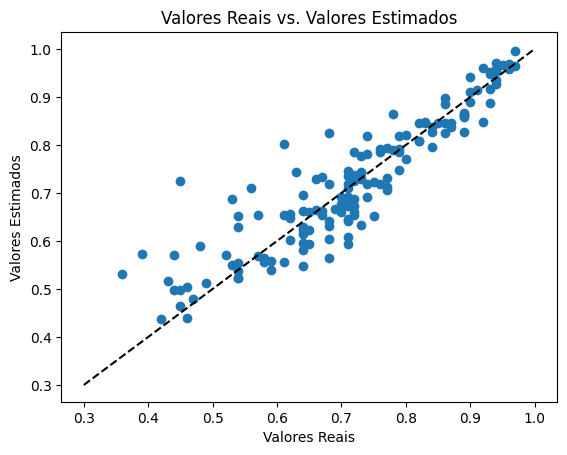

In [15]:
plt.scatter(y_test, y_pred)
plt.plot([0.3, 1], [0.3, 1], '--k')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Estimados')
plt.title('Valores Reais vs. Valores Estimados')
plt.show()

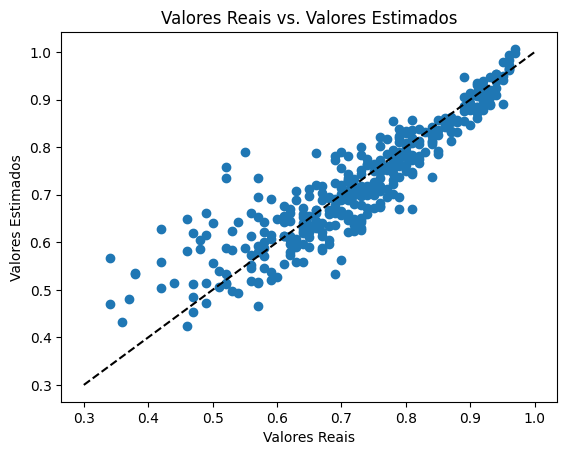

In [16]:
y_pred_train = np.dot(X_train_bias, coefficients)
plt.scatter(y_train, y_pred_train)
plt.plot([0.3, 1], [0.3, 1], '--k')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Estimados')
plt.title('Valores Reais vs. Valores Estimados')
plt.show()